In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import utils
import numpy as np

from xwmt.preprocessing import preprocessing
from xwmt.swmt import swmt

from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt

import gsw

In [3]:
rootdir = '/projects/SOCCOM/scratch/gpfs/graemem/'
rootdir_ds = rootdir+'jra55_wmt/'
rootdir_grid = rootdir+'jra55/'

In [4]:
ds = xr.open_zarr(rootdir_ds+'jra55.en4.ds.zarr').drop('depth')
grid = xr.open_dataset(rootdir_grid+'areacella_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-5-0_gr.nc')
ds = ds.rename({'lat':'y','lon':'x'})
grid = grid.rename({'lat':'y','lon':'x'})

In [5]:
ds['wet'] = np.isfinite(ds['sos'])
ds['sfdsi'] = xr.zeros_like(ds['hfds'])
ds['areacello'] = grid['areacella'].copy()
# ds['sigma0'] = gsw.sigma0(ds['sos'],ds['tos'])
# ds['alpha'] = gsw.alpha(ds['sos'],ds['tos'],0)
# ds['beta'] = gsw.beta(ds['sos'],ds['tos'],0)

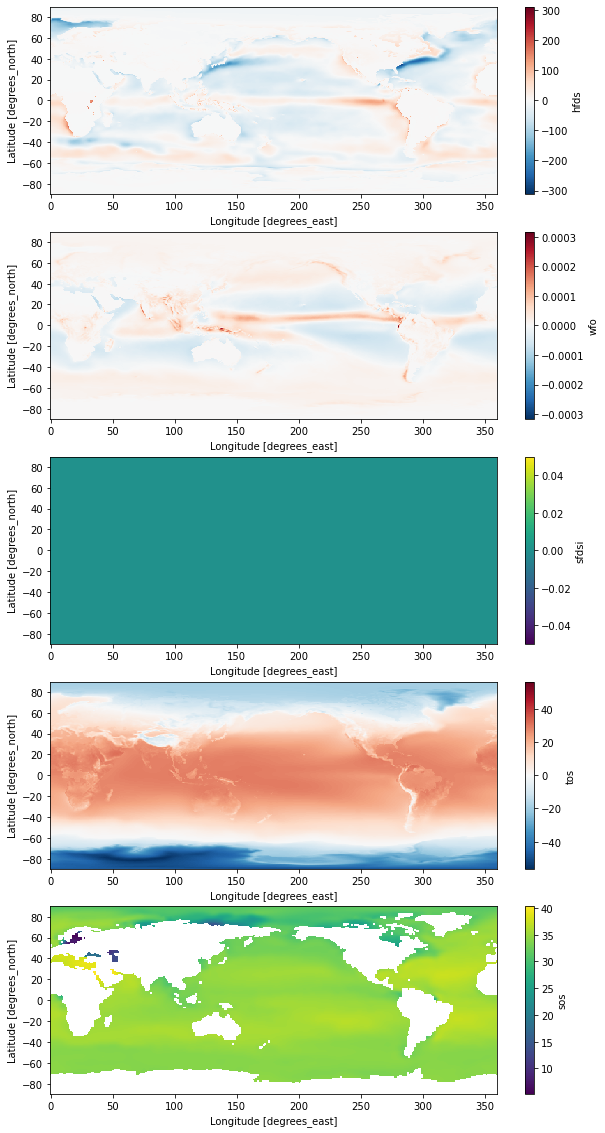

In [6]:
varnames = ['hfds','wfo','sfdsi','tos','sos']
nv = len(varnames)
fig,ax = plt.subplots(figsize=(10,4*nv),nrows=nv)
for i,varname in enumerate(varnames):
    da = ds[varname].isel(time=slice(0,120)).mean('time')
    da.plot(ax=ax[i])

In [31]:
# Redefine lat and lon for density calculation
ds['lat']=ds['y']*xr.ones_like(ds['x'])
ds['lon']=ds['x']*xr.ones_like(ds['y'])
# Chunk in time
ds = ds.chunk({'time':60})

In [32]:
jra_swmt = swmt(ds)
jra_swmt.ds

<xarray.Dataset>
Dimensions:    (y: 320, lev_outer: 2, time: 768, x: 640, lev: 1)
Coordinates:
  * y          (y) float64 -89.57 -89.01 -88.45 -87.89 ... 88.45 89.01 89.57
  * x          (x) float64 0.0 0.5625 1.125 1.688 ... 357.8 358.3 358.9 359.4
  * time       (time) datetime64[ns] 1958-01-16 1958-02-13 ... 2021-12-16
  * lev_outer  (lev_outer) float64 0.0 5.0
  * lev        (lev) float64 2.5
Data variables:
    hfds       (lev_outer, time, y, x) float32 dask.array<chunksize=(2, 60, 320, 640), meta=np.ndarray>
    sos        (lev_outer, time, y, x) float32 dask.array<chunksize=(2, 60, 320, 640), meta=np.ndarray>
    tos        (lev_outer, time, y, x) float32 dask.array<chunksize=(2, 60, 320, 640), meta=np.ndarray>
    wfo        (lev_outer, time, y, x) float32 dask.array<chunksize=(2, 60, 320, 640), meta=np.ndarray>
    wet        (time, y, x) bool dask.array<chunksize=(60, 320, 640), meta=np.ndarray>
    sfdsi      (lev_outer, time, y, x) float32 dask.array<chunksize=(2, 60, 320, 640), meta=np.ndarray>
    areacello  (y, x) float32 dask.array<chunksize=(320, 640), meta=np.ndarray>
    lat        (y, x) float64 dask.array<chunksize=(320, 640), meta=np.ndarray>
    lon        (x, y) float64 dask.array<chunksize=(640, 320), meta=np.ndarray>

In [41]:
save = False
l = 'theta'
lmin = -2
lmax = 30
dl = 0.5
bins = np.arange(lmin,lmax,dl)
G = jra_swmt.G(l, bins=bins, group_tend=False)
# G['heat'] = G['heat'].assign_attrs({
#     'long_name':'watermass transformation due to surface heat fluxes',
#     'units':'m3s-1'})
# G['salt'] = G['salt'].assign_attrs({
#     'long_name':'watermass transformation due to surface salt and freshwater fluxes',
#     'units':'m3s-1'})

In [42]:
with ProgressBar():
    G = G.load()

[########################################] | 100% Completed | 20.48 s


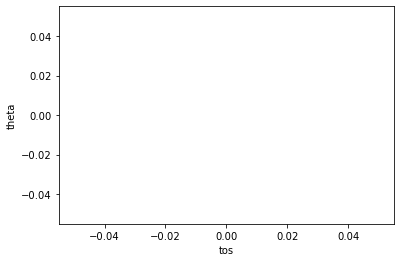

In [43]:
G.mean('time').plot()

In [44]:
G

<xarray.DataArray 'theta' (time: 768, tos: 63)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * time     (time) datetime64[ns] 1958-01-16 1958-02-13 ... 2021-12-16
  * tos      (tos) float64 -1.75 -1.25 -0.75 -0.25 ... 27.75 28.25 28.75 29.25

In [29]:
G['heat'].mean('time').plot(label='heat')
# G['salt'].plot(label='salt')
# G['total'].plot(label='total')
# plt.gca().legend()

KeyError: 'heat'

In [37]:
_,_,sigma0 = jra_swmt.get_density('sigma0')

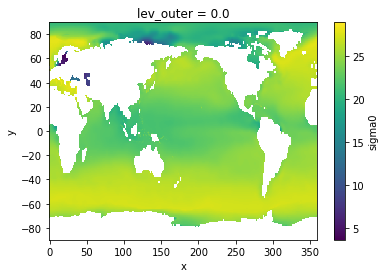

In [38]:
sigma0.isel(time=slice(0,120),lev_outer=0).mean('time').plot()

In [30]:
sigma0

<xarray.DataArray 'sigma0' (lev_outer: 2, time: 768, y: 320, x: 640)>
dask.array<transpose, shape=(2, 768, 320, 640), dtype=float64, chunksize=(2, 60, 320, 640), chunktype=numpy.ndarray>
Coordinates:
  * y          (y) float64 -89.57 -89.01 -88.45 -87.89 ... 88.45 89.01 89.57
  * x          (x) float64 0.0 0.5625 1.125 1.688 ... 357.8 358.3 358.9 359.4
  * time       (time) datetime64[ns] 1958-01-16 1958-02-13 ... 2021-12-16
  * lev_outer  (lev_outer) float64 0.0 5.0

# SCRIBBLES

In [46]:
swmt(ds).G(lstr='sigma0',bins=bins,process=['hfds'])

TypeError: swmt.calc_G() got an unexpected keyword argument 'process'

In [ ]:
## MAIN
class swmt():
    masterdict = {
        "hfds":{'associated_scalar':'tos','flux_or_tendency':'flux','intensive_or_extensive':'extensive'},
        "sfdsi":{'associated_scalar':'sos','flux_or_tendency':'flux','intensive_or_extensive':'extensive'},
        "wfo":{'associated_scalar':'sos','flux_or_tendency':'flux','intensive_or_extensive':'extensive',
                'massflux':True,'scalar_in_massflux':0,'scalar_at_boundary':'sos'}
                 }
    
    def __init__(self,ds):
        data_vars = ds.data_vars
        # Check that all necessary attributes are there, or add them if not
        for data_var in data_vars:
            self[data_var]=ds[data_vars].copy()
            attrs = self[data_var].attrs
            
            if data_var in masterdict.keys:
                attrs_expected = masterdict[data_var]
                if attrs != attrs_expected:
                    # Return an error
                    # data_var has a CMOR convention name but the attributes don't match
            if 'associated_scalar' not in attrs:
                # Return an error
                
                # Or derive from cmor convention
              
    def G(lstr,bins,pstrs):
        if lstr=='sigma0' & lstr not in self.data_vars:
            l = calc_density(self.sa,self.theta)
        else:
            l = self[lstr]
        G = xr.Dataset()
        for pstr in pstrs:
            if lstr=='sigma0':
                process = calc_densityflux(self[pstr])
            elif self[pstr].attrs['associated_scalar']!=lstr:
                # Return an error, or simply zero?
                
            G[process]=_G_singleprocess(l,bins,process)

In [ ]:
## GRID


In [ ]:
## THERMODYNAMICS
def _calc_density(salinity,temperature,eos='teos10'):
    if eos=='teos10':
        return gsw.sigma0(salinity,temperature)
    
def _calc_alpha():
    
def _calc_beta():
    
def _calc_densityflux(process):
    attrs = process.attrs
    if attrs['associated_scalar']=='tos':
        coeff=self['alpha']*Cp
    elif attrs['associated_scalar']=='sos':
        coeff=self['beta']/self['rho0']
    return coeff*process

In [ ]:
## WMT
def _G_singleprocess(l,bins,process):
    hldot = calc_hldot(process)
    G = histogram(l,bins=bins,weights=hldot*area,dims=['x','y','z'])/np.diff(bins)

In [56]:
## PROCESS
def _calc_hldot(xgrid,process,intensive_or_extensive=None,flux_or_tendency=None):
    if (intensive_or_extensive=="intensive") & (flux_or_tendency=="flux"):
        hldot = hldot_from_Jl(xgrid,process)
    elif (intensive_or_extensive=="intensive") & (flux_or_tendency=="tendency"):
        hldot = hldot_from_ldot(xgrid,process)
    elif (intensive_or_extensive=="extensive") & (flux_or_tendency=="flux"):
        hldot = hldot_from_JL(xgrid,process)
    elif (intensive_or_extensive=="extensive") & (flux_or_tendency=="tendency"):
        hldot = hldot_from_Ldot(xgrid,process)
        
    return hldot

def _calc_hldot_massflux(xgrid,process,scalar_in_massflux,scalar_at_boundary):
    # Special case
    Jl = Jl_from_massflux(process,scalar_in_massflux,scalar_at_boundary)
    hldot = hldot_from_Jl(xgrid,Jl)
    
    return hldot
        
def calc_hldot(da,xgrid):
    
    ### Checking if it has necessary attributes ###
    attrs = da.attrs
    # Scrap attributes except those desired
    desired = ["flux_or_tendency","intensive_or_extensive","massflux","scalar_in_massflux","scalar_at_boundary"]
    attrs = dict_retain_keys(attrs,desired)
    if len(attrs)==0:
        print(processname+" has no WMT-relevant attributes so is not being considered")
        return
    
    ### Checking whether it is a 2D surface flux ###
    # If it is, place it on the very upper interface of the grid, and set zero elsewhere
    if "z_i" not in da.dims:
        ds[processname] = expand_surface_to_3D(ds[processname],ds["z_i"])
    
    # Special case that the process is associated with a boundary mass flux 
    # (commonly freshwater flux at the ocean surface)
    if "massflux" in attrs:
        # Requires that other attributes also be specified (could check for this higher up)
        if (attrs["scalar_in_massflux"] is None) or (attrs["scalar_at_boundary"] is None):
            print("To evaluate WMT due to boundary mass fluxes requires that the scalar"+
                  "concentration in the mass flux and the scalar concentration at the"+
                  "exposed boundary be specified")
        else:
            scalar_in_massflux = attrs["scalar_in_massflux"]
            if isinstance(attrs["scalar_at_boundary"],str):
                scalar_at_boundary = ds[attrs["scalar_at_boundary"]]
            else:
                scalar_at_boundary = attrs["scalar_at_boundary"]
            hldot = _calc_hldot_massflux(xgrid,ds[processname],scalar_in_massflux,scalar_at_boundary)
    else:
        hldot = _calc_hldot(xgrid,ds[processname],**attrs)
        
    return hldot

Data variables:
    hfds       (time, y, x) float32 dask.array<chunksize=(60, 320, 640), meta=np.ndarray>
    sos        (time, y, x) float32 dask.array<chunksize=(60, 320, 640), meta=np.ndarray>
    tos        (time, y, x) float32 dask.array<chunksize=(60, 320, 640), meta=np.ndarray>
    wfo        (time, y, x) float32 dask.array<chunksize=(60, 320, 640), meta=np.ndarray>
    wet        (time, y, x) bool dask.array<chunksize=(60, 320, 640), meta=np.ndarray>
    sfdsi      (time, y, x) float32 dask.array<chunksize=(60, 320, 640), meta=np.ndarray>
    areacello  (y, x) float32 dask.array<chunksize=(320, 640), meta=np.ndarray>
    lat        (y, x) float64 dask.array<chunksize=(320, 640), meta=np.ndarray>
    lon        (x, y) float64 dask.array<chunksize=(640, 320), meta=np.ndarray>